# 1. Data Analysis and Preparation

## 1.1 Load and Summarize Data
- Load `Country-data.csv` into a pandas DataFrame.
- Print the header using `DataFrame.head()`.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import numpy as np

In [2]:
url = "https://raw.githubusercontent.com/Hunteracademic/Unsupervised_assignment_1/master/Country-data.csv"
country_data = pd.read_csv(url)
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
country_data.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000



-**Use `DataFrame.describe()` to summarize the dataset.**

- There are 9 different columns with numerical data that descriptive statistics can use. 
- Notable there are 167 different counties in this dataset that represent each row. 


**Explain the meaning of each column.**


- **country**: Name of the country.  
- **child_mort**: Death of children under 5 years of age per 1000 live births.  
- **exports**: Exports of goods and services per capita, given as percentage of the GDP per capita.  
- **health**: Total health spending per capita, given as percentage of GDP per capita.  
- **imports**: Imports of goods and services per capita, given as percentage of the GDP per capita.  
- **income**: Net income per person.  
- **inflation**: Measurement of the annual growth rate of the total GDP.  
- **life_expec**: Average number of years a newborn child would live if current mortality patterns remain the same.  
- **total_fer**: Number of children that would be born to each woman if current age-fertility rates remain the same.  
- **gdpp**: GDP per capita, calculated as total GDP divided by total population.  


**Make observations based on the summary statistics.**

- The above statistics seem like the common considered socioeconomic factors when trying to evaluate a countries average living conditions. Non of the values seem to be very unrealistic in terms of extremely high or low values.
- There are several features that are represented as percentages of the total GDP per capita of each specific country.
- The `income` features seems to be skewed to the left comparing the value of the mean vs the median.
- Many variables span orders of magnitude. Income ranges from about 609 to 125000 and gdpp from 231 to 105000, indicating a strong need for scaling before clustering.
- `child_mort` is skewed to the right.


**Discuss whether these statistics provide useful insights.**


- Percentages can be used to calculate actual money values in case is needed when performing predictions.
- Health spending as a percentage of GDP per capita is centered around 6.8 with a relatively small standard deviation and a maximum near 18, indicating less dispersion than trade or income variables.
- There is a good mix of features that enable analysis from a socioeconomic perspective, clustering countries accordingly.
- We think that using those statistics we can locate countries in need of aid. We are going to look for a group of countries with low income, healthcare spending, life expectancy and GDP and have high import rates, inflation, child mortality. Then we can further compare countries in this group to rank the countries with lowest living conditions and allocate our finding accordingly.


## 1.2 Data Integrity and Cleaning
- Use `DataFrame.info()` to check data types and missing values.
- Use `DataFrame.duplicated()` to identify duplicate entries.
- Clean the dataset:
  - Remove missing values.
  - Drop duplicate rows.
  - Correct any incorrect data types.
- Document the cleaning process and changes in Markdown.


In [4]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
print(country_data.duplicated().sum())

0


In [6]:
print(country_data.isna().sum())

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


 Initial exploration did not show any null or duplicate values.

 **Important Note:** Even though cleaning was not needed, some of the columns may present outlier, given the skewness of some of the features we could get from `describe()`

## 1.3 Feature Correlation and Visualization
- Drop the `country` column and store it separately.
- Use `seaborn.heatmap()` to display the correlation matrix.
- Use `seaborn.pairplot()` to generate scatter plots and histograms.
- Record observations in Markdown:
  - Discuss insights gained from the visualizations.


In [7]:
No_country_data = country_data.drop("country", axis=1)
country = country_data["country"]
No_country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [8]:
country

0              Afghanistan
1                  Albania
2                  Algeria
3                   Angola
4      Antigua and Barbuda
              ...         
162                Vanuatu
163              Venezuela
164                Vietnam
165                  Yemen
166                 Zambia
Name: country, Length: 167, dtype: object

Text(0.5, 1.0, 'Correlation Heatmap of Country Data')

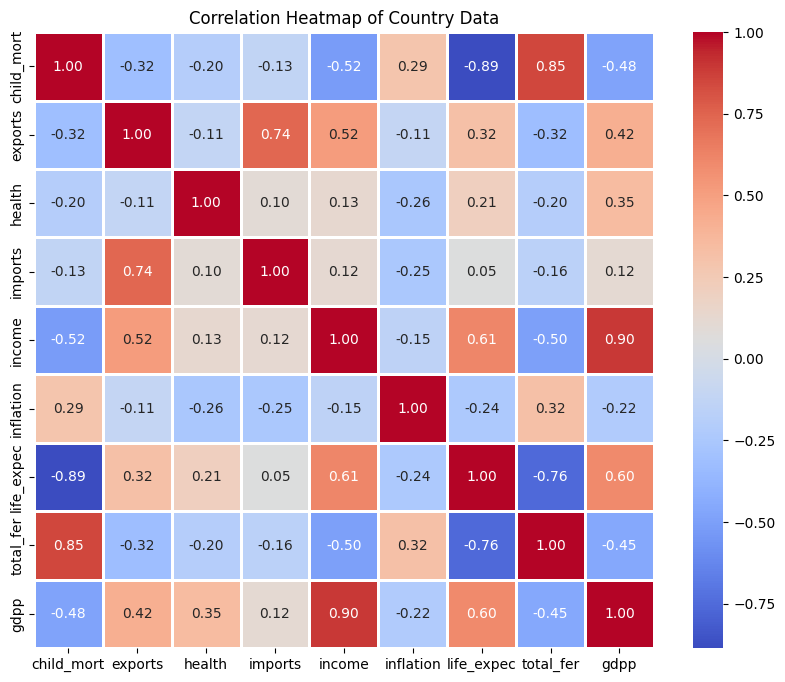

In [9]:
corr = No_country_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=1
)
plt.title("Correlation Heatmap of Country Data")

In [10]:
corr.to_numpy().flatten()

array([ 1.        , -0.31809322, -0.20040206, -0.12721092, -0.52431502,
        0.28827617, -0.8866761 ,  0.84847811, -0.48303217, -0.31809322,
        1.        , -0.1144084 ,  0.73738083,  0.5167836 , -0.10729439,
        0.3163126 , -0.32001055,  0.41872475, -0.20040206, -0.1144084 ,
        1.        ,  0.09571668,  0.12957861, -0.25537579,  0.21069212,
       -0.19667399,  0.34596553, -0.12721092,  0.73738083,  0.09571668,
        1.        ,  0.12240625, -0.24699428,  0.05439053, -0.15904843,
        0.11549817, -0.52431502,  0.5167836 ,  0.12957861,  0.12240625,
        1.        , -0.147756  ,  0.61196247, -0.50184005,  0.89557143,
        0.28827617, -0.10729439, -0.25537579, -0.24699428, -0.147756  ,
        1.        , -0.23970496,  0.31692107, -0.22163106, -0.8866761 ,
        0.3163126 ,  0.21069212,  0.05439053,  0.61196247, -0.23970496,
        1.        , -0.76087469,  0.60008913,  0.84847811, -0.32001055,
       -0.19667399, -0.15904843, -0.50184005,  0.31692107, -0.76

#### Insights from Correlation Heatmap
- There are several features strongly related to each other (expected behaviour), with the highest correlation between `income` and `gdpp`, as well as a strong correlation between the `total_fer` and `child_mort` columns.
- We are going to avoid this high correlations in the clustering process as we consider both features would provide the same information and clustering wouldn't make sense.
- Our strategy is to look for feature pairs that actually present a better distribution of data points, as well as useful information to determine the coutries that need more help.

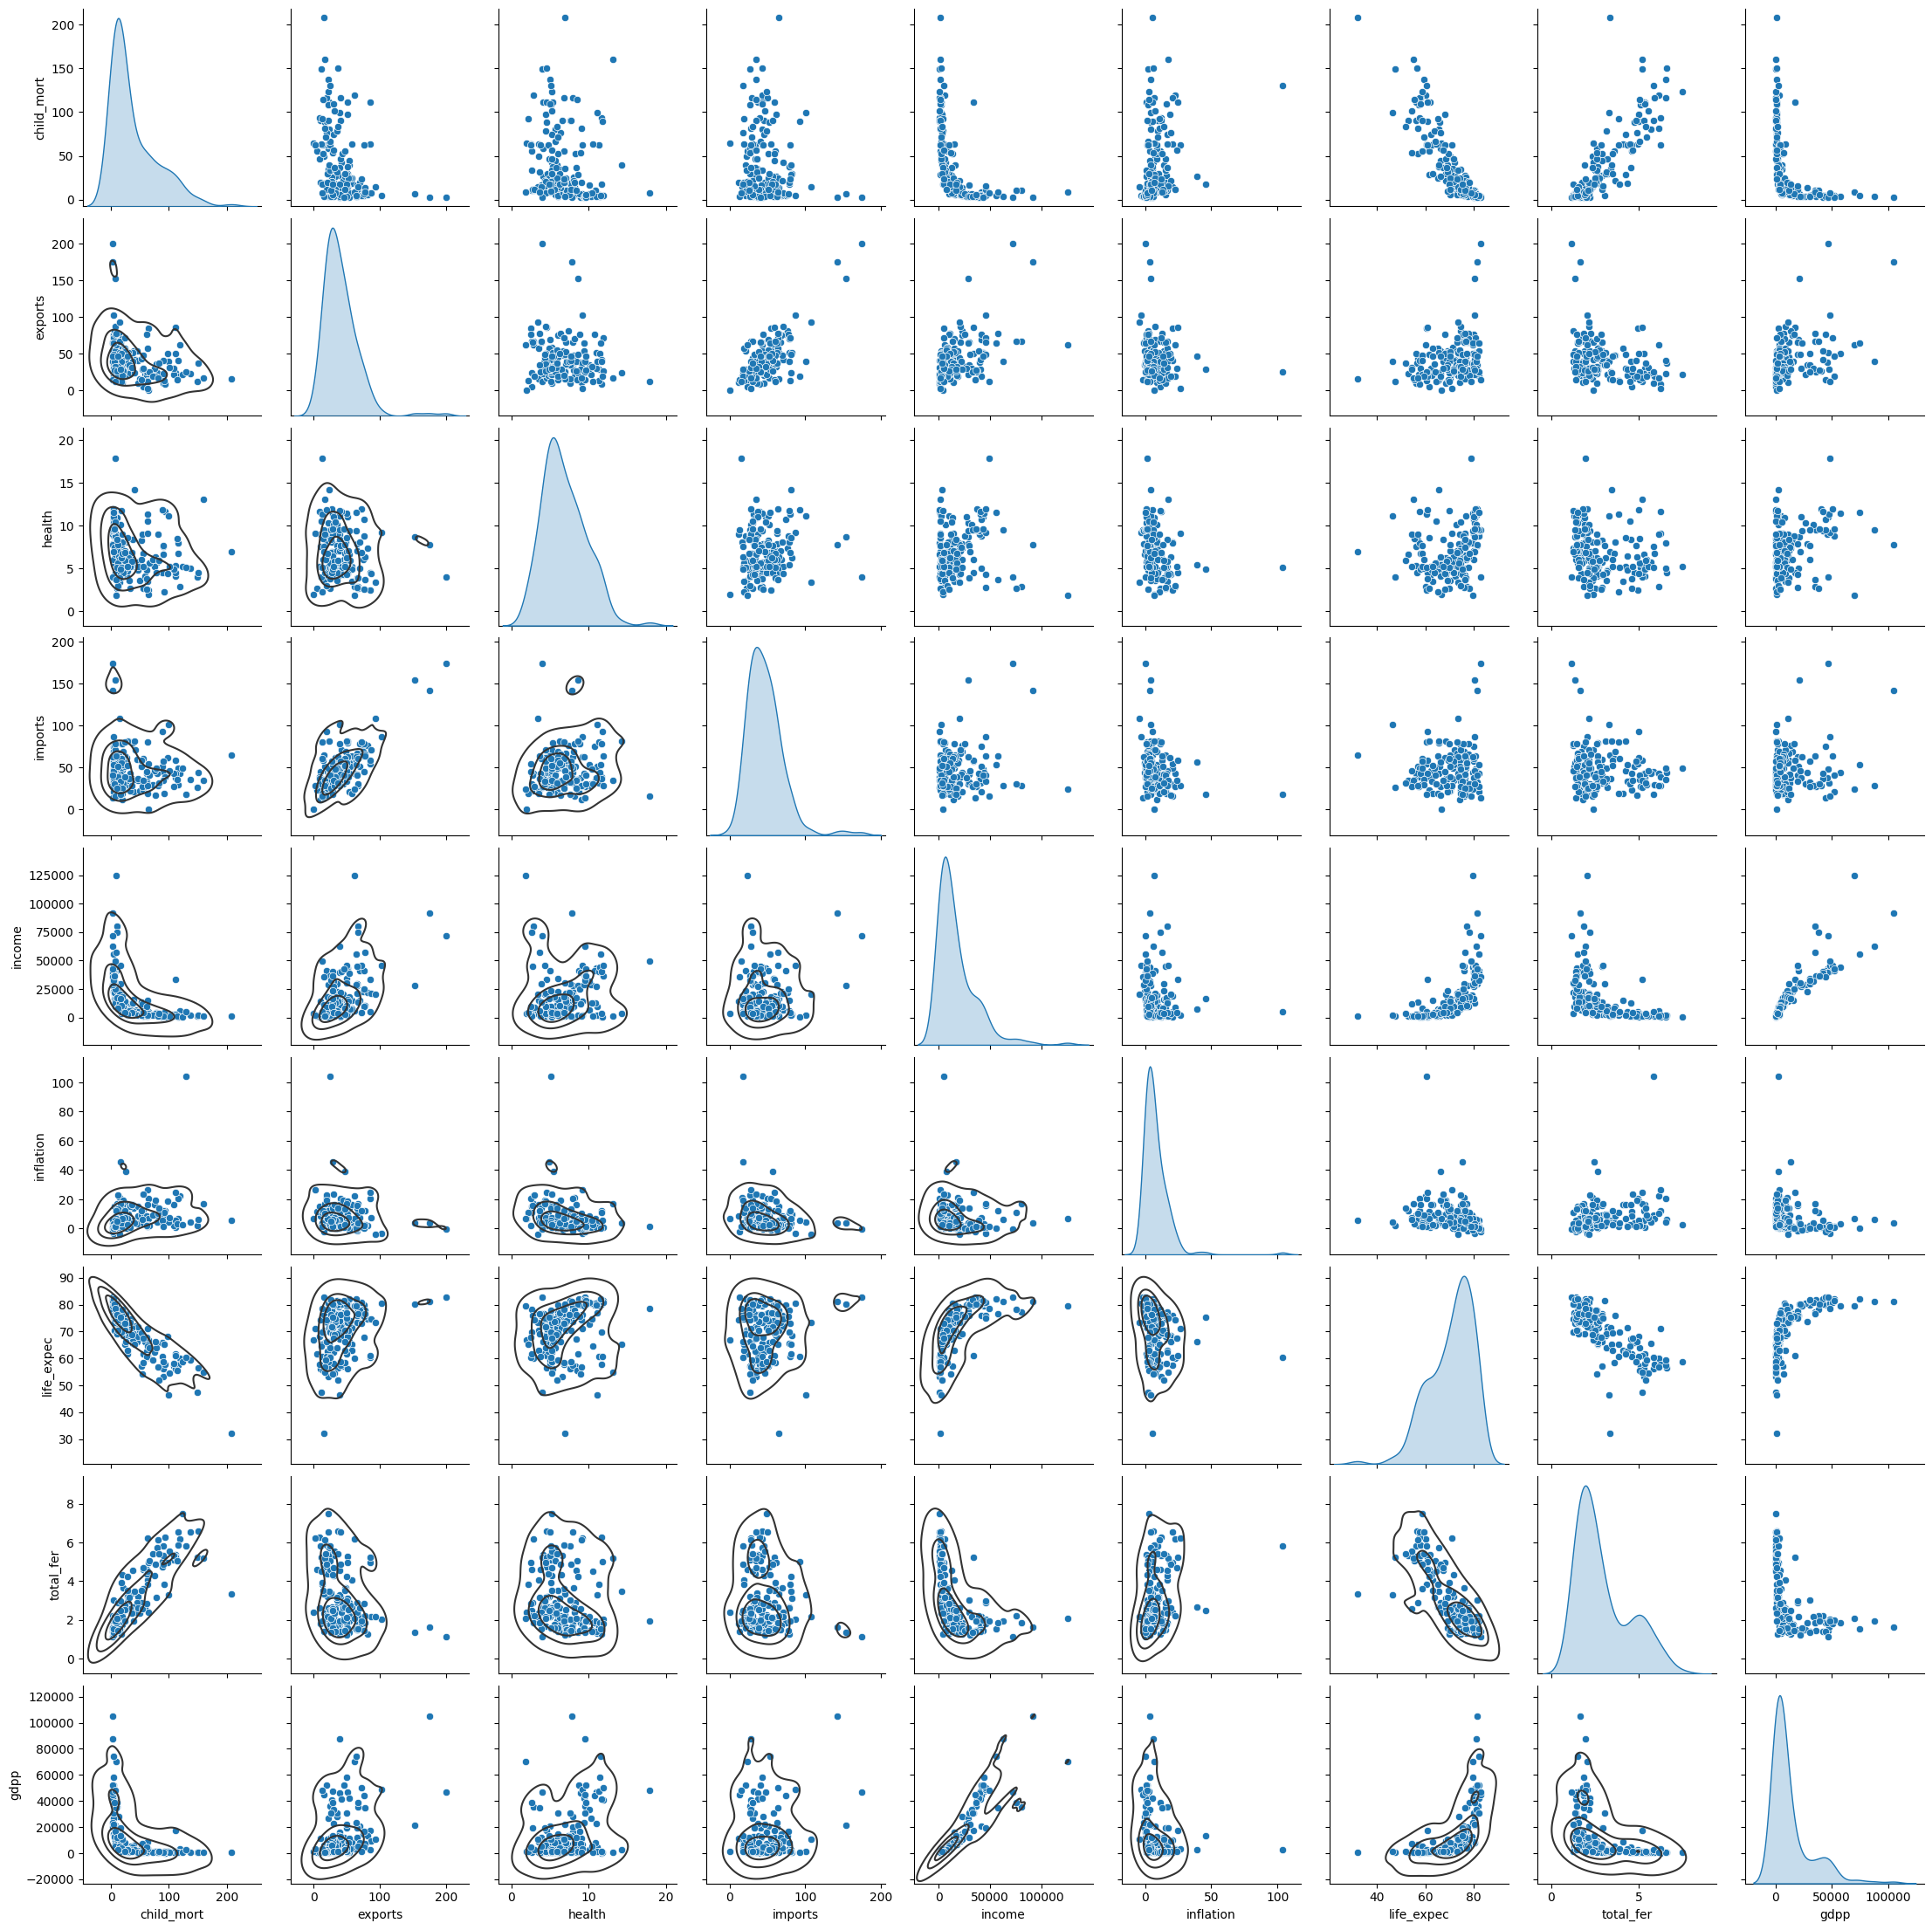

In [11]:
#ns.pairplot(No_country_data)

g = sns.pairplot(No_country_data, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

# The pairplot that she gave us outputs a ton of info. 
### After this visual we have more specific graphs for insights on high or low correlated features.
##### *change the hashtag to see a different set of the pairplot*
##### *adjust as you feel necessary*

### Pairplot Insights
- 
- 
- 

# Below are more graphs for visualization, they are reiterating the pairplot graph 

# *Do we need these?*

### Insights
- 
- 
- 



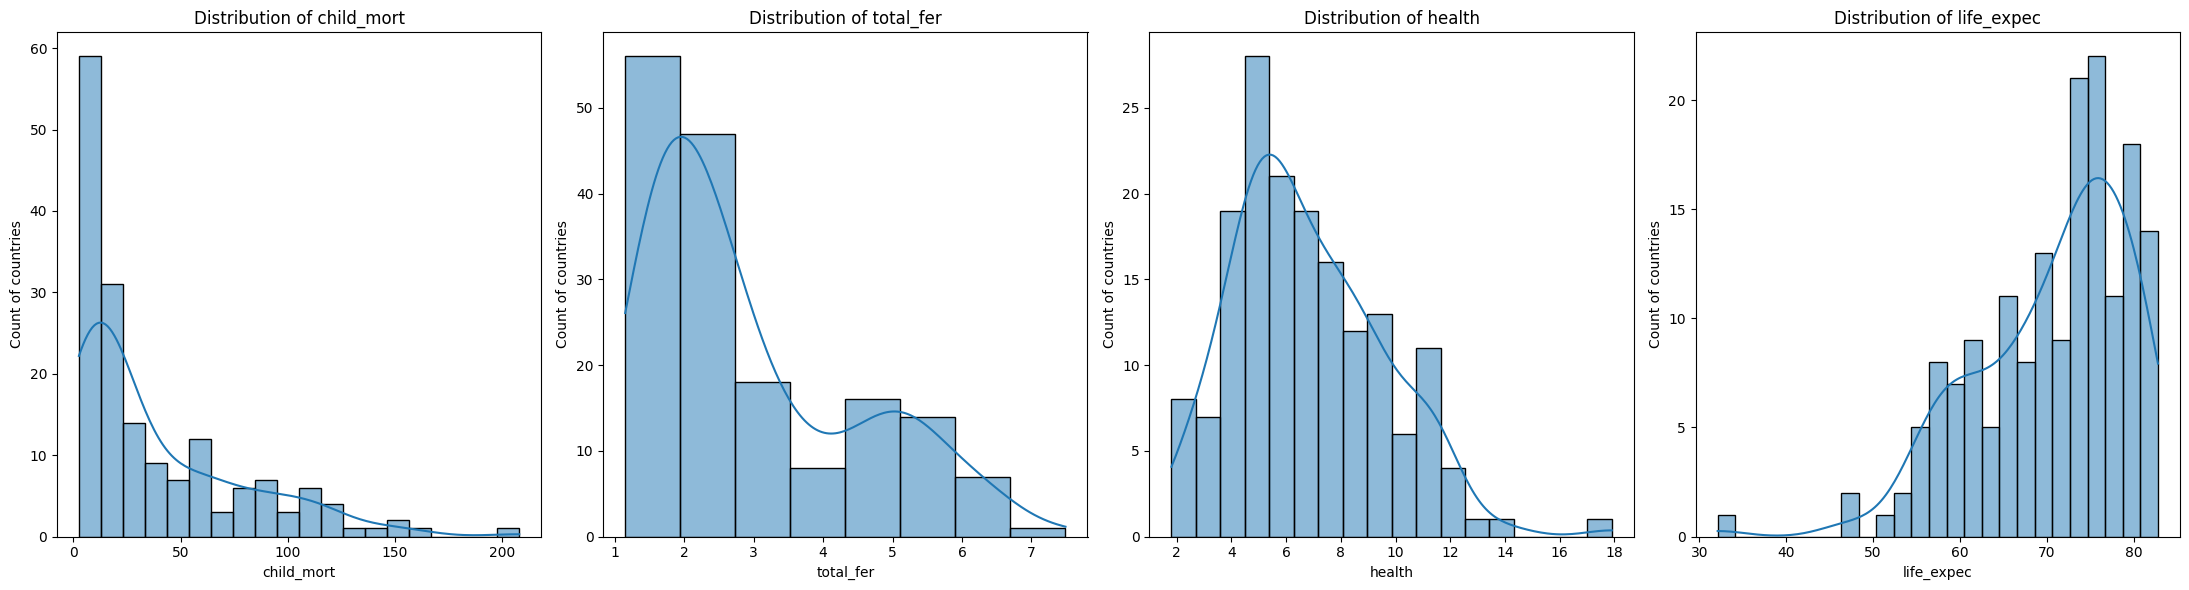

In [12]:
def histogram(df, column, bin_s, ax):
    sns.histplot(
        data=df,
        x=column,
        bins= bin_s,
        kde=True,
        ax=axes[ax]
    )
    axes[ax].set_title(f"Distribution of {column}")
    axes[ax].set_xlabel(f"{column}")
    axes[ax].set_ylabel("Count of countries")

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 6))

histogram(No_country_data, "child_mort", 20,  0)
histogram(No_country_data, "total_fer", 8, 1)
histogram(No_country_data, "health", 18, 2)
histogram(No_country_data, "life_expec",25, 3)

plt.tight_layout()
plt.show()


# 2. Clustering and Modeling

## 2.1 Data Scaling
- Use `sklearn.preprocessing.StandardScaler` to scale the data.
- Print the transformed header.


In [13]:
No_country_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [14]:
scaler = StandardScaler()
scaled = scaler.fit_transform(No_country_data)
df_scaled = pd.DataFrame(scaled, columns=No_country_data.columns, index=No_country_data.index)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946,-0.041817



## 2.2 KMeans Clustering and Evaluation
- Use `sklearn.cluster.KMeans` to cluster the data.
- Try `n_clusters` values in the range [2, 10].
- Calculate the silhouette score for each value.
- Plot silhouette score vs. number of clusters.


In [15]:
def k_means(X, K):
#Keep track of history so you can see K-Means in action
    centroids_history = []
    labels_history = []
    rand_index = np.random.choice(X.shape[0], K)  
    centroids = X[rand_index]
    centroids_history.append(centroids)
    while True:
# Euclidean distances are calculated for each point relative to centroids, #and then np.argmin returns
# the index location of the minimal distance - which cluster a point is #assigned to
        labels = np.argmin(cdist(X, centroids), axis=1)
        labels_history.append(labels)
#Take mean of points within clusters to find new centroids:
        new_centroids = np.array([X[labels == i].mean(axis=0)
                                for i in range(K)])
        centroids_history.append(new_centroids)
        
        # If old centroids and new centroids no longer change, K-Means is complete and end. Otherwise continue
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    return centroids, labels, centroids_history, labels_history


Text(0, 0.5, 'Silhouette Scores')

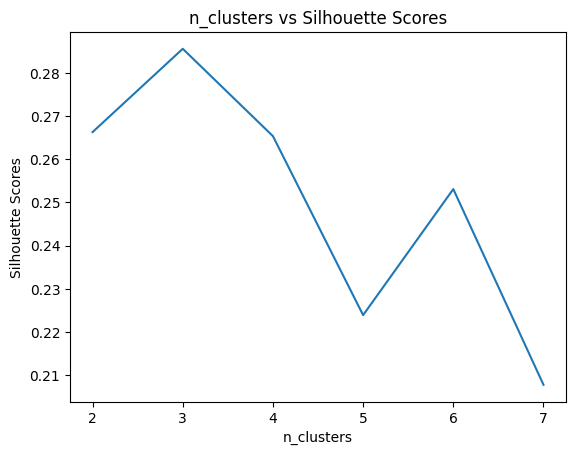

In [16]:
np.random.seed(0)
silhouette_score_list = []
n_clusters = range(2,8)
for i in n_clusters:
    centroids, labels, _, _ = k_means(df_scaled.values, i)
    silhouette_score_list.append(silhouette_score(df_scaled, labels))

sns.lineplot(x=n_clusters,y=silhouette_score_list)
plt.title('n_clusters vs Silhouette Scores')
plt.xlabel('n_clusters')
plt.ylabel('Silhouette Scores')


## 2.3 Model Selection and Justification
- Choose the best model based on silhouette scores and other criteria. Justify the selected number of clusters in Markdown. Save the corresponding model as the best model.

**R/:** According to the silhouette score visualization, we can say the 3 clusters seem to be well defined for the dataset, as we consider all the features to obtain this scores. **This is not our final decision, we'll consider looking into how do this number of cluster behave for specific choosen feature pairs, and will change it if necessary.**


# 3. Conclusion

## 3.1 Cluster Visualization

We decided to create a function that trains a k-means algorithm given a number of clusters and 2 features for practicity and testing.


In [45]:
def try_features_pair(feature_x, feature_y, n_clusters):
        np.random.seed(0)
        centroids, labels, _, _ = k_means(df_scaled[[feature_x, feature_y]].values, n_clusters)

        plt.figure(figsize=(10,7))
        plt.scatter(df_scaled[feature_x], df_scaled[feature_y], c=labels,
                s=50, cmap='tab20b');
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red')
        plt.xlabel(feature_x)
        plt.ylabel(feature_y)
        plt.title(f'K-Means Clustering of {feature_x} vs {feature_y}')  
        plt.show()
        return pd.DataFrame(df_scaled.index).join(pd.DataFrame(labels, columns=['Cluster']))

def tester(feature_x, feature_y, n_clusters):
        np.random.seed(0)
        centroids, labels, _, _ = k_means(df_scaled[[feature_x, feature_y]].values, n_clusters)

        plt.figure(figsize=(10,7))
        plt.scatter(df_scaled[feature_x], df_scaled[feature_y], c=labels,
                s=50, cmap='tab20b');
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red')
        plt.xlabel(feature_x)
        plt.ylabel(feature_y)
        plt.title(f'K-Means Clustering of {feature_x} vs {feature_y}')  
        plt.show()
        df_result = pd.DataFrame(df_scaled.index).join(pd.DataFrame(labels, columns=['Cluster']))
        df_result = df_result.join(country_data['country'])[['Cluster', 'country']]
        sns.histplot(df_result['Cluster'], bins=5)
        plt.title('Cluster Distribution')
        plt.show()
        clusters_indexes = list(df_result['Cluster'].unique())
        clusters_indexes.sort()
        for i in clusters_indexes:
                print(f"Countries in Cluster {i}:")
                countries_in_cluster = df_result[df_result['Cluster'] == i]['country'].values
                print(countries_in_cluster)
                
        

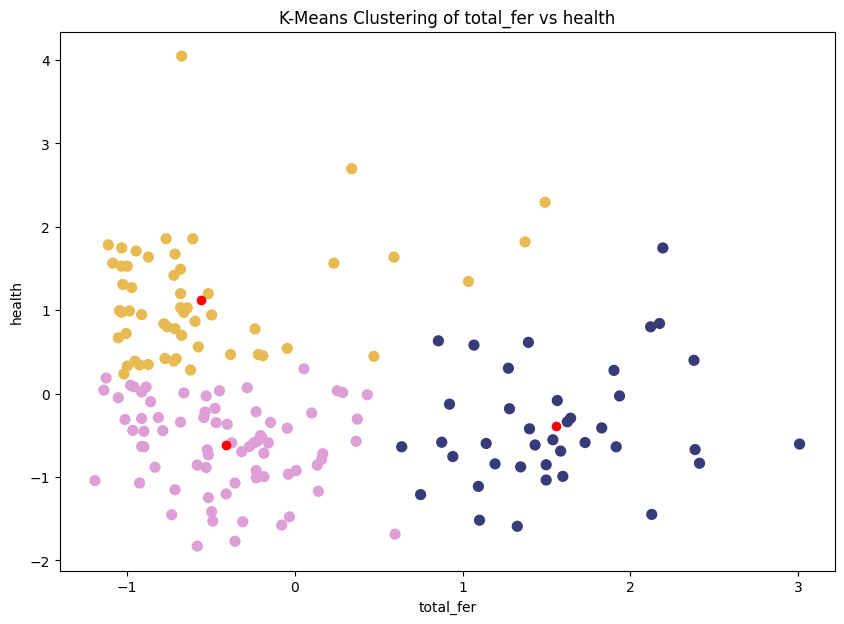

In [46]:
cluster_df = try_features_pair('total_fer', 'health', 3)
cluster_df = cluster_df.join(country_data['country'])[['Cluster', 'country']]

In [47]:
cluster_df

,Cluster,country
0,0,Afghanistan
1,2,Albania
2,2,Algeria
3,0,Angola
4,2,Antigua and Barbuda
...,...,...
162,2,Vanuatu
163,2,Venezuela
164,2,Vietnam
165,0,Yemen


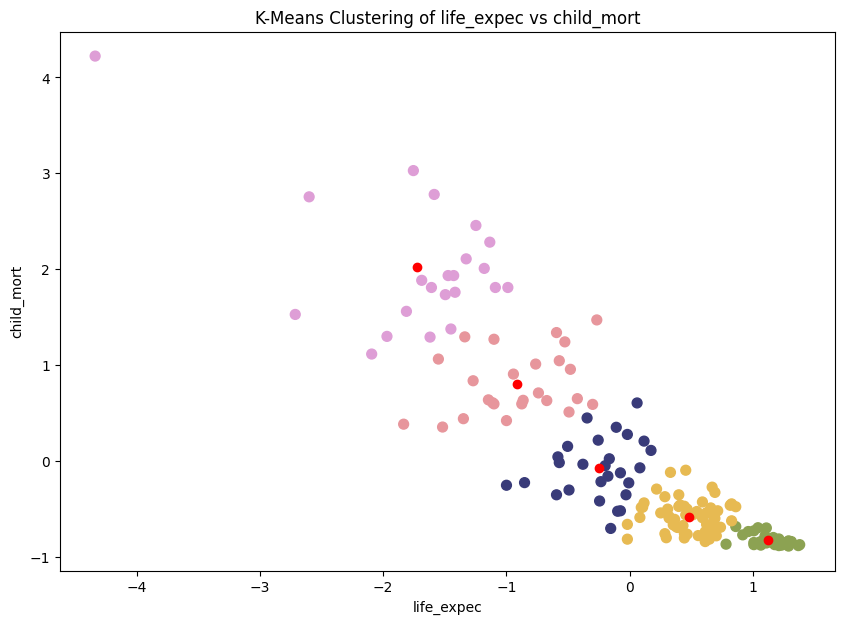

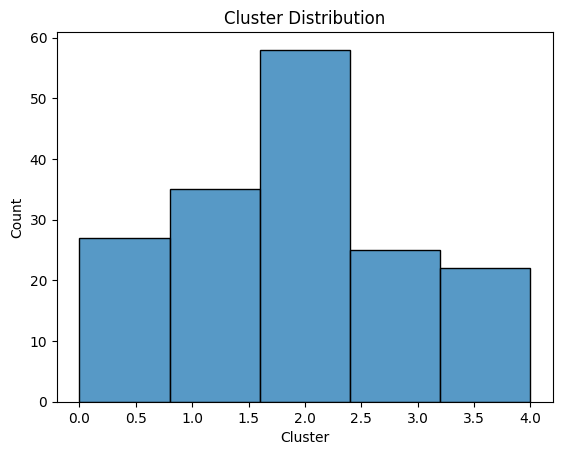

Countries in Cluster 0:
['Azerbaijan' 'Bangladesh' 'Bhutan' 'Bolivia' 'Cambodia' 'Egypt' 'Fiji'
 'Guatemala' 'Guyana' 'Indonesia' 'Iraq' 'Kazakhstan' 'Kyrgyz Republic'
 'Micronesia, Fed. Sts.' 'Moldova' 'Mongolia' 'Nepal' 'Philippines'
 'Russia' 'Solomon Islands' 'Suriname' 'Tajikistan' 'Timor-Leste' 'Tonga'
 'Uzbekistan' 'Vanuatu' 'Yemen']
Countries in Cluster 1:
['Australia' 'Austria' 'Belgium' 'Canada' 'Chile' 'Costa Rica' 'Cyprus'
 'Czech Republic' 'Denmark' 'Finland' 'France' 'Germany' 'Greece'
 'Iceland' 'Ireland' 'Israel' 'Italy' 'Japan' 'Kuwait' 'Lebanon'
 'Luxembourg' 'Malta' 'Netherlands' 'New Zealand' 'Norway' 'Portugal'
 'Qatar' 'Singapore' 'Slovenia' 'South Korea' 'Spain' 'Sweden'
 'Switzerland' 'United Kingdom' 'United States']
Countries in Cluster 2:
['Albania' 'Algeria' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Bahamas'
 'Bahrain' 'Barbados' 'Belarus' 'Belize' 'Bosnia and Herzegovina' 'Brazil'
 'Brunei' 'Bulgaria' 'Cape Verde' 'China' 'Colombia' 'Croatia'
 'Dominican

In [ ]:
tester('life_expec', 'child_mort', 5) # I like this one

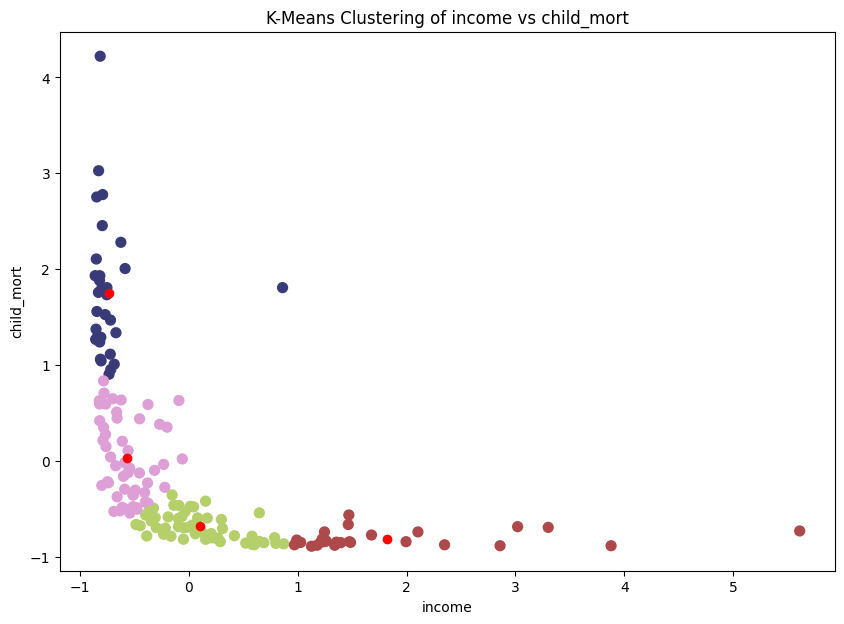

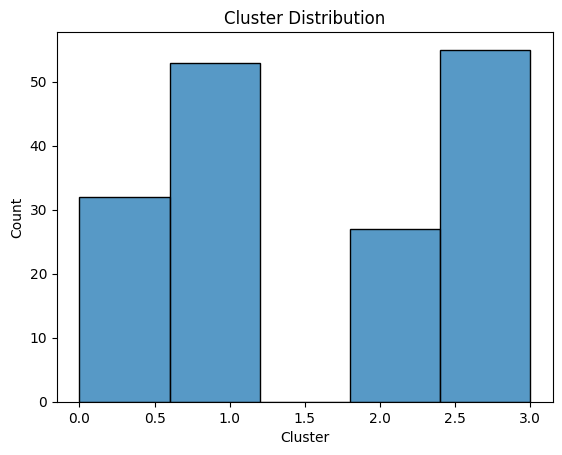

Countries in Cluster 0:
['Afghanistan' 'Angola' 'Benin' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 "Cote d'Ivoire" 'Equatorial Guinea' 'Gambia' 'Ghana' 'Guinea'
 'Guinea-Bissau' 'Haiti' 'Lao' 'Lesotho' 'Liberia' 'Malawi' 'Mali'
 'Mauritania' 'Mozambique' 'Niger' 'Nigeria' 'Pakistan' 'Sierra Leone'
 'Sudan' 'Togo' 'Uganda' 'Zambia']
Countries in Cluster 1:
['Albania' 'Antigua and Barbuda' 'Argentina' 'Bahamas' 'Barbados'
 'Belarus' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Chile' 'China'
 'Colombia' 'Costa Rica' 'Croatia' 'Cyprus' 'Czech Republic' 'Estonia'
 'Greece' 'Grenada' 'Hungary' 'Iran' 'Israel' 'Kazakhstan' 'Latvia'
 'Lebanon' 'Libya' 'Lithuania' 'Macedonia, FYR' 'Malaysia' 'Maldives'
 'Malta' 'Mauritius' 'Montenegro' 'New Zealand' 'Panama' 'Poland'
 'Portugal' 'Romania' 'Russia' 'Serbia' 'Seychelles' 'Slovak Republic'
 'Slovenia' 'South Korea' 'Spain' 'Sri Lanka' 'Suriname' 'Thailand'
 'Tunisia' 'Turkey' 'Ukraine' 'U

In [51]:
tester('income', 'child_mort', 4)

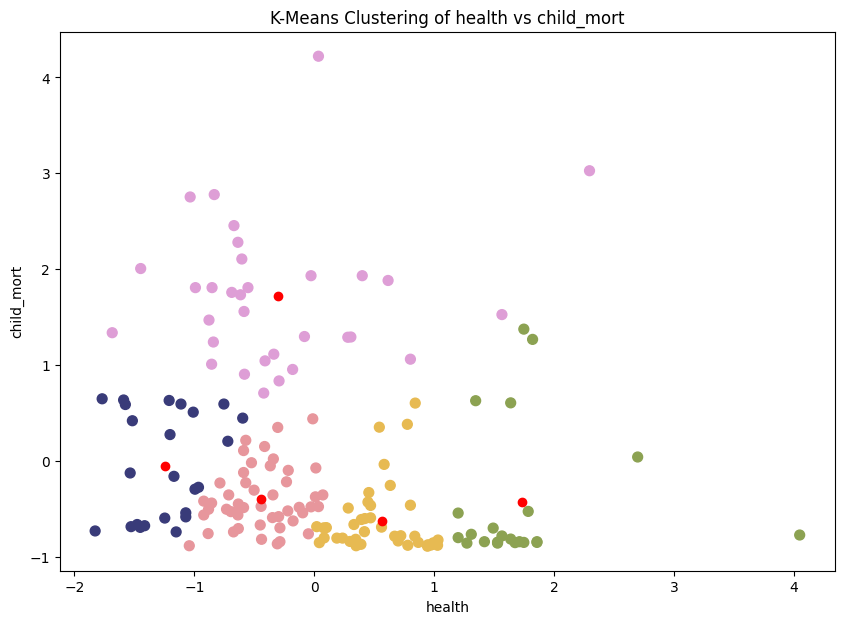

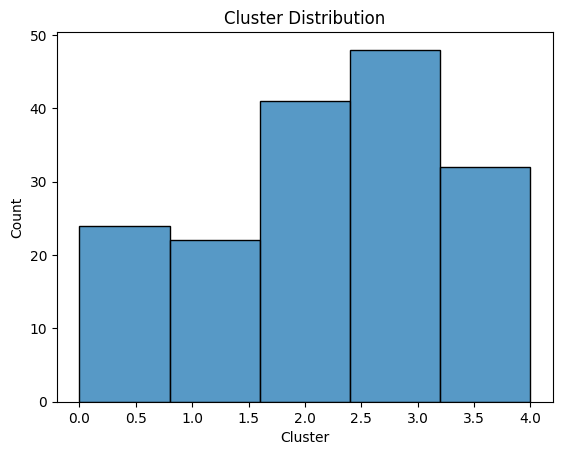

Countries in Cluster 0:
['Algeria' 'Bangladesh' 'Bolivia' 'Brunei' 'Cape Verde' 'Congo, Rep.'
 'Eritrea' 'Gabon' 'India' 'Indonesia' 'Kenya' 'Kuwait' 'Libya'
 'Madagascar' 'Myanmar' 'Oman' 'Philippines' 'Qatar' 'Seychelles'
 'Sri Lanka' 'Thailand' 'Turkmenistan' 'United Arab Emirates' 'Yemen']
Countries in Cluster 1:
['Austria' 'Belgium' 'Bosnia and Herzegovina' 'Burundi' 'Canada'
 'Costa Rica' 'Denmark' 'France' 'Georgia' 'Germany' 'Greece' 'Kiribati'
 'Liberia' 'Micronesia, Fed. Sts.' 'Moldova' 'Netherlands' 'New Zealand'
 'Portugal' 'Rwanda' 'Serbia' 'Switzerland' 'United States']
Countries in Cluster 2:
['Argentina' 'Australia' 'Bahamas' 'Barbados' 'Botswana' 'Brazil'
 'Bulgaria' 'Chile' 'Colombia' 'Croatia' 'Czech Republic' 'Ecuador'
 'Finland' 'Hungary' 'Iceland' 'Iraq' 'Ireland' 'Israel' 'Italy' 'Japan'
 'Jordan' 'Lebanon' 'Lithuania' 'Luxembourg' 'Macedonia, FYR' 'Malta'
 'Montenegro' 'Norway' 'Panama' 'Poland' 'Slovak Republic' 'Slovenia'
 'Solomon Islands' 'South Africa' 'Sou

In [56]:
tester('health', 'child_mort', 5)


## 3.2 Cluster Size Distribution
- Generate a histogram showing the number of countries in each cluster.
- Provide observations in Markdown:
  - Discuss whether the cluster sizes make sense.


Text(0.5, 1.0, 'Cluster Distribution')

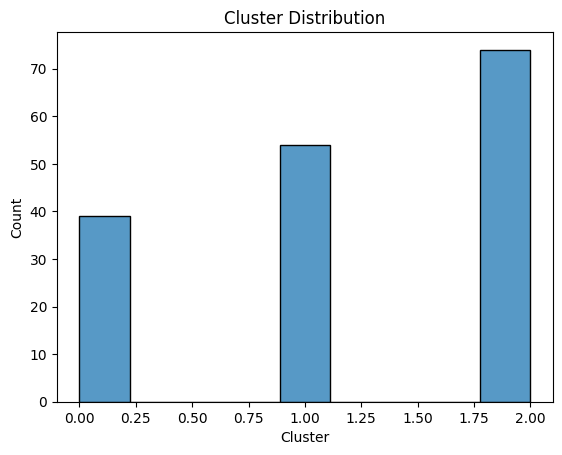

In [260]:
sns.histplot(cluster_df['Cluster'])
plt.title('Cluster Distribution')


## 3.3 Cluster Composition and Ranking
- Print the country names in each cluster.
- Comment on the logical coherence of the results.
- Rank clusters from most aid-needed to least.
- Use quick research to verify alignment with real-world conditions.
- Summarize findings in Markdown.


In [ ]:
clusters_indexes = list(cluster_df['Cluster'].unique())
clusters_indexes.sort()

for i in clusters_indexes:
    print(f"Countries in Cluster {i}:")
    countries_in_cluster = cluster_df[cluster_df['Cluster'] == i]['country'].values
    print(countries_in_cluster)
    print()

Countries in Cluster 0:
['Afghanistan' 'Angola' 'Benin' 'Burkina Faso' 'Burundi' 'Cameroon'
 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' "Cote d'Ivoire" 'Equatorial Guinea' 'Eritrea' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Iraq' 'Kenya' 'Madagascar'
 'Malawi' 'Mali' 'Mauritania' 'Mozambique' 'Niger' 'Nigeria' 'Samoa'
 'Senegal' 'Solomon Islands' 'Sudan' 'Tanzania' 'Timor-Leste' 'Togo'
 'Tonga' 'Uganda' 'Yemen' 'Zambia']

Countries in Cluster 1:
['Argentina' 'Australia' 'Austria' 'Bahamas' 'Barbados' 'Belgium'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Canada' 'Chile' 'Colombia'
 'Costa Rica' 'Croatia' 'Czech Republic' 'Denmark' 'Ecuador' 'Finland'
 'France' 'Georgia' 'Germany' 'Greece' 'Iceland' 'Ireland' 'Italy' 'Japan'
 'Jordan' 'Kiribati' 'Lesotho' 'Liberia' 'Luxembourg' 'Malta'
 'Micronesia, Fed. Sts.' 'Moldova' 'Montenegro' 'Netherlands'
 'New Zealand' 'Norway' 'Panama' 'Poland' 'Portugal' 'Rwanda' 'Serbia'
 'Sierra Leone' 'Slovak 


## 3.4 Fund Allocation Strategy
- Describe which countries will receive funds.
- Specify how much each country will receive.
- Justify the allocation strategy.